## Deterministic Optimisation Model

### Step-1: Import data and technology libraries

In [1]:
import pulp as pl
import pandas as pd
import numpy as np
import numpy_financial as npf
import matplotlib.pyplot as plt

# Load energy demand, weather data, price data
tdata = pd.read_csv('Data/EnergyWeatherPrice24_5Y_avg_weather1.csv')
# tdata = pd.read_csv('Data/EnergyWeatherPrice24_5Y_avg_weather2.csv')

# Load day types count
day_count = pd.read_csv('Data/DayTypeCount.csv',index_col='DayType_i')

# Import battery library and convert into dictionary
batt_df = pd.read_csv('Data/battery_library.csv')
batt_lib = batt_df.set_index('type').T.to_dict()

# Import PV library and convert into dicionary
pv_df = pd.read_csv('Data/pv_library.csv')
pv_lib = pv_df.set_index('type').T.to_dict()

# Create technology types list to iterate through the library
batt_type = list(batt_lib.keys())
pv_type = list(pv_lib.keys())

### Step-2: Define simulation parameters

In [2]:
# Results output
csv_out = 0 # 1: print results to new row in existing csv; 0: print results to a blank csv (reset csv output files)

# Simulaiton length
years_sim = 15 # Length of simulation in years
timestep_size = 1 # Define timestep resolution in hours

# User defined technology selection
user_sel = 0 # 1: user selects the tech, 0: model selects the tech
pv_sel = 1 # PV type selection, see 'type' column in the library for index
batt_sel = 1 # Battery type selection, see 'type' column in the library for index
pv_ins = 1 # 1: install PV, 0: no PV installed
batt_ins = 1 # 1: install batt, 0: no batt installed

# Grid export
ex_op = 0 # 1: electricity export monetised; 0: electricity export not monetised

# Building parameters
max_ex = 320 # Maximum electricity export (kW)
max_im = 237 # Maximum electricity import (kW)
peak_demand = 208.23 # Building's estimated instantaneous peak electricity demand (kW)
peak_sustain = 3 # Number of hours the building sustains the peak load (kW)
A_roof = 2647 # Total roof surface area (m2)
lamda_roof = 0.6 # Fraction of total roof that can be installed with PV
w_roof = 16 # Roof loading capacity (kg/m2)
battR_vol = 67.7 # Volume of battery room (assume 40-ft container for Hook)
lamda_battR = 0.4 # Fraction of total battery room volume that can be installed with batterys

# Technonology parameters
max_soc_set = 1 # User defined max soc
min_soc_set = 0.4 # User defined min soc
batt_mrgn = 1.2 # Design margin for battery power output, user defined

# Financial parameters
years_fin = 5 # Length of financial analysis in years
disc_rate = 0.1 # Discount rate
present_val = np.array([1 / (1 + disc_rate) ** y for y in range(years_sim+1)])
infl_rate = 0.04 # Inflation rate
infl_val = np.array([(1 + infl_rate) ** y for y in range(years_sim+1)])

# Electricity price increase
CCL_increase = 0.05 # Environmental tarrifs increase per year
DUoS_increase = 0.03 # DUoS cost increase per year
Whl_increase = 0.035 # Wholesale price increase per year

### Step-3: Extend timeseries data to simulation length

In [3]:
# Extend the DataFrame to cover simulation length by repeating the data
extended_data = pd.concat([tdata] * years_sim, ignore_index=True)

# Create the year column
rows_per_year = len(extended_data) // years_sim
year_column = [year for year in range(years_sim) for x in range(rows_per_year)]

# Add the year column to the dataframe
extended_data['Year'] = year_column

# Reorder the columns to have 'Year' as the left-most column
cols = ['Year'] + [col for col in extended_data if col != 'Year']
extended_data = extended_data[cols]

# Get the unique years
unique_years = extended_data['Year'].unique()

# Apply the increase for each year. 
for year in unique_years:
    
    factor_DUoS = (1 + DUoS_increase) ** (year)
    extended_data.loc[extended_data['Year'] == year, 'DUoS export (GBP/kWh)'] *= factor_DUoS
    extended_data.loc[extended_data['Year'] == year, 'DUoS import (GBP/kWh)'] *= factor_DUoS
    
    factor_Whl = (1 + Whl_increase) ** (year)
    extended_data.loc[extended_data['Year'] == year, 'Wholesale (GBP/kWh)'] *= factor_Whl

    factor_CCL = (1 + CCL_increase * 0.9647 / 16) ** (year)
    extended_data.loc[extended_data['Year'] == year, 'Misc (GBP/kWh)'] *= factor_CCL

extended_data['Import Price (GBP/kWh)'] = extended_data['Wholesale (GBP/kWh)'] + extended_data['DUoS import (GBP/kWh)'] + extended_data['Misc (GBP/kWh)']
extended_data['Export Price (GBP/kWh)'] = extended_data['Wholesale (GBP/kWh)'] + extended_data['DUoS export (GBP/kWh)']

extended_data

,Year,DayType_i,Hour,Air Temperature (degC),Energy Demand (kWh),Irradiance (W/m2),DUoS export (GBP/kWh),DUoS import (GBP/kWh),Wholesale (GBP/kWh),Misc (GBP/kWh),Export Price (GBP/kWh),Import Price (GBP/kWh),DRH (GBP/MW/hr),DRL (GBP/MW/hr)
0,0,1,0,3.443304,75.721185,0.0,0.000320,0.000350,0.058163,0.160000,0.058483,0.218513,-3.536087,8.640435
1,0,1,1,3.378417,84.586953,0.0,0.000320,0.000350,0.056872,0.160000,0.057192,0.217222,-3.536087,8.640435
2,0,1,2,3.311565,83.584439,0.0,0.000320,0.000350,0.052463,0.160000,0.052783,0.212813,-3.536087,8.640435
3,0,1,3,3.282391,87.332262,0.0,0.000320,0.000350,0.051057,0.160000,0.051377,0.211407,-3.536087,8.640435
4,0,1,4,3.257391,82.942428,0.0,0.000320,0.000350,0.052010,0.160000,0.052330,0.212360,-5.900435,10.586522
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8635,14,24,19,5.881420,94.140705,0.0,0.010089,0.011269,0.125978,0.166887,0.136067,0.304134,-4.993000,10.242000
8636,14,24,20,5.740560,96.015871,0.0,0.010089,0.011269,0.114427,0.166887,0.124516,0.292583,-2.100000,9.146000
8637,14,24,21,5.608100,96.044481,0.0,0.010089,0.011269,0.106373,0.166887,0.116461,0.284528,-2.100000,9.146000
8638,14,24,22,5.490220,75.850322,0.0,0.000484,0.000529,0.081304,0.166887,0.081788,0.248720,-2.100000,9.146000


### Step-4: Model equipment degradation and replacement

In [4]:
# Initialise dictionaries for equipment state of health
health_pv = {}
health_inv = {}
health_batt = {}

# Initialise dictionaries for number of replacement
rep_pv = {}
rep_inv = {}
rep_batt = {}

# Initialize dictionaries for time counter
year_since_last_rep_pv = {}
year_since_last_rep_inv = {}
year_since_last_rep_batt = {}

for p in pv_type:
    # Initialise time counter
    year_since_last_rep_pv[p] = 0
    year_since_last_rep_inv[p] = 0

for b in batt_type: 
    # Initialise time counter
    year_since_last_rep_batt[b] = 0

for year in range(years_sim):
    
    # Initialise health dictionary
    health_pv[year] = {}
    health_inv[year] = {}
    health_batt[year] = {}

    # Initialise replacement dictionary
    rep_pv[year] = {}
    rep_inv[year] = {}
    rep_batt[year] = {}

    for p in pv_type:
        
        # Initialise replacement value
        rep_pv[year][p] = 0
        rep_inv[year][p] = 0

        if year == 0:
        # Initialise equipment degradation
            health_pv[year][p] = 1
            health_inv[year][p] = 1
        else:
        # Calculate equipment degradation
            health_pv[year][p] = health_pv[year-1][p] - pv_lib[p]['deg_pv']
            health_inv[year][p] = health_inv[year-1][p] - pv_lib[p]['deg_inv']
        
        # Check for PV replacement
        if year_since_last_rep_pv[p] >= pv_lib[p]['life_pv']:
            rep_pv[year][p] = 1
            health_pv[year][p] = 1  # Reset health
            year_since_last_rep_pv[p] = 0 # Reset the counter

        # Check for inverter replacement
        if year_since_last_rep_inv[p] >= pv_lib[p]['life_inv']:
            rep_inv[year][p] = 1
            health_inv[year][p] = 1  # Reset health
            year_since_last_rep_inv[p] = 0 # Reset the counter

        # Increment for time counter
        year_since_last_rep_pv[p] += 1
        year_since_last_rep_inv[p] += 1
        
    for b in batt_type:

        # Initialise replacement value
        rep_batt[year][b] = 0

        if year == 0:
            # Initialise equipment degradation
            health_batt[year][b] = 1
        else:
            # Calculate equipment degradation
            health_batt[year][b] = health_batt[year-1][b] - batt_lib[b]['deg_batt']

        # Check for battery replacement
        if year_since_last_rep_batt[b] >= batt_lib[b]['life_batt']:
            rep_batt[year][b] = 1
            health_batt[year][b] = 1  # Reset health
            year_since_last_rep_batt[b] = 0 # Reset the counter

        # Increment for time counter
        year_since_last_rep_batt[b] += 1 

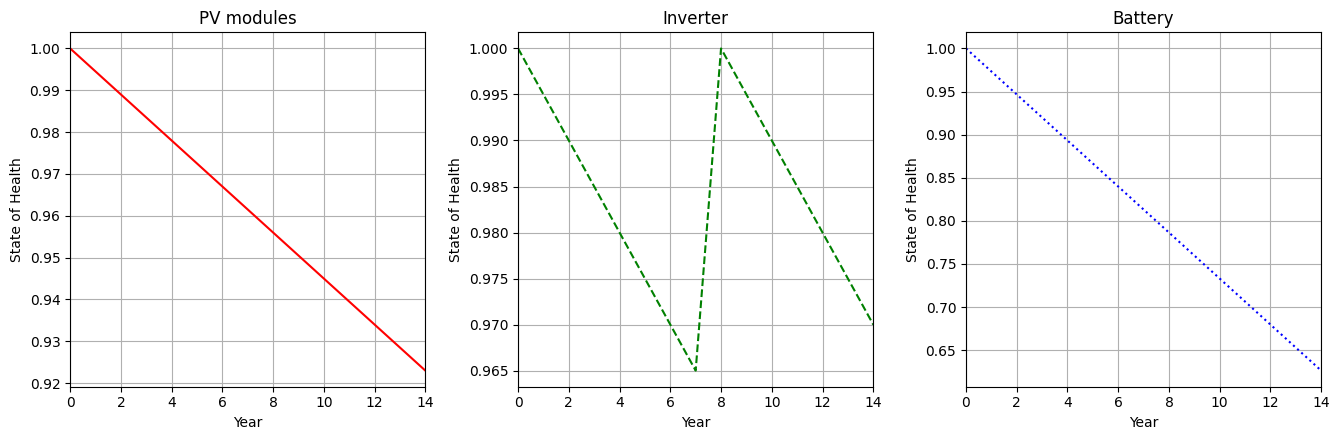

In [5]:
# Extract data for plotting for 15 years
years = list(range(years_sim))
m_si_health_pv = [health_pv[year][1] for year in years]
m_si_health_inv = [health_inv[year][1] for year in years]
lfp_health_batt = [health_batt[year][2] for year in years]

# Creating a single figure with 3 subplots in a 3-column, 1-row layout
plt.figure(figsize=(13.5, 4.5))

# Subplot 1: PV Health for 'm-Si'
plt.subplot(1, 3, 1)
plt.plot(years, m_si_health_pv, label='PV Health: m-Si', color='red')
plt.xlabel('Year')
plt.xlim(0, 14)
plt.ylabel('State of Health')
plt.title('PV modules')
plt.grid(True)

# Subplot 2: Inverter Health for 'm-Si'
plt.subplot(1, 3, 2)
plt.plot(years, m_si_health_inv, label='Inverter Health: m-Si', linestyle='--', color='green')
plt.xlabel('Year')
plt.xlim(0, 14)
plt.ylabel('State of Health')
plt.title('Inverter')
plt.grid(True)

# Subplot 3: Battery Health for 'LFP'
plt.subplot(1, 3, 3)
plt.plot(years, lfp_health_batt, label='Battery Health: LFP', linestyle=':', color='blue')
plt.xlabel('Year')
plt.xlim(0, 14)
plt.ylabel('State of Health')
plt.title('Battery')
plt.grid(True)

plt.tight_layout()
plt.show()

### Step-5: Create LP optimisation problem and define variables

In [6]:
# Create linear programming problem
model = pl.LpProblem("15-year_NPC_Minimise", pl.LpMinimize)

# Create lists for year, day_type, hour indexes
year_i = list(extended_data['Year'].unique())
day_type_i = list(extended_data['DayType_i'].unique())
hour_i = list(extended_data['Hour'].unique())

# Define continuous variables
N_pv = pl.LpVariable.dicts("N_pv", pv_type, lowBound = 0, cat=pl.LpInteger) # Number of PV modules
E_batt = pl.LpVariable.dicts("E_batt", batt_type, lowBound = 0, cat=pl.LpContinuous) # Battery energy capacity
O_batt = pl.LpVariable.dicts("O_batt", batt_type, lowBound = 0, cat=pl.LpContinuous) # Battery power capacity
E_im = pl.LpVariable.dicts("E_im", (year_i, day_type_i, hour_i), lowBound=0, cat=pl.LpContinuous) # Electricity import
E_ex = pl.LpVariable.dicts("E_ex", (year_i, day_type_i, hour_i), lowBound=0, cat=pl.LpContinuous) # Electricity export
E_batt_c = pl.LpVariable.dicts("E_batt_c", (year_i, day_type_i, hour_i, batt_type), lowBound=0, cat=pl.LpContinuous) # Baterring charging
E_batt_d = pl.LpVariable.dicts("E_batt_d", (year_i, day_type_i, hour_i, batt_type), lowBound=0, cat=pl.LpContinuous) # Battery discharging

# Define binary variables
beta_batt = pl.LpVariable.dicts("beta_batt", batt_type, cat=pl.LpBinary) # Battery selection binary
beta_pv = pl.LpVariable.dicts("beta_pv", pv_type, cat=pl.LpBinary) # PV selection binary
beta_im = pl.LpVariable.dicts("beta_im", (year_i, day_type_i, hour_i), cat=pl.LpBinary) # Import exclusivity binary
beta_ex = pl.LpVariable.dicts("beta_ex", (year_i, day_type_i, hour_i), cat=pl.LpBinary) # Export exclusivity binary
beta_c = pl.LpVariable.dicts("beta_c", (year_i, day_type_i, hour_i), cat=pl.LpBinary) # Battery charging exclusivity binary
beta_d = pl.LpVariable.dicts("beta_d", (year_i, day_type_i, hour_i), cat=pl.LpBinary) # Battery discharge exclusivity binary

### Step-6: Set technology selection and design constraints

In [7]:
for p in pv_type:
    # PV type selection
    model += N_pv[p] <= beta_pv[p] * 10e9 * pv_ins

    # Constraint to ensure the number of installed PV panels do not exceed roof size
    model += N_pv[p] <= A_roof * lamda_roof * pl.lpSum(beta_pv[p] * (1 / pv_lib[p]['A_pv']) for p in pv_type)

    # Constraint to ensure total PV weight do not exceed roof loading capacity
    model += N_pv[p] <= A_roof * w_roof * pl.lpSum(beta_pv[p] * (1 / pv_lib[p]['w_pv']) for p in pv_type)

for b in batt_type:
    # Battery type selection
    model += E_batt[b] <= beta_batt[b] * 10e9 * batt_ins # Battery energy capacity
    model += O_batt[b] <= beta_batt[b] * 10e9 * batt_ins # Battery power output

    # Constraint to ensure battery + PCS volume do not exceed battery room volume
    model += pl.lpSum(O_batt[b] * batt_mrgn * (1/batt_lib[b]['vol_pcs']) + E_batt[b] * (1/batt_lib[b]['vol_batt']) for b in batt_type) <= battR_vol * lamda_battR

    # Constraint to ensure that battery power output and max electricity import can meet building's peak demand
    model += pl.lpSum(O_batt[b] for b in batt_type) + max_im >= peak_demand
            
# Constraints to ensure only one technology type is selected
model += pl.lpSum(beta_batt[b] for b in batt_type) == 1
model += pl.lpSum(beta_pv[p] for p in pv_type) == 1

# Constraints for user defined selection
if user_sel == 1:
    model += beta_batt[batt_sel] == user_sel
    model += beta_pv[pv_sel] == user_sel

### Step-7: Set energy balance and all related components

Defined in this cell are:
- ENERGY BALANCE
- PV generation model, along with PV and inverter degradation
- PV max generation constraint
- Battery degradation model (residual capacity)
- Battery energy level at every time step
- Battery charge/discharge schedule constraint
- Battery SOC limit
- Battery charge/discharge limit
- Grid import/export limit

In [8]:
# Initialise dictionaries for calculation results
E_pv_yt_dict = {}
E_batt_lvl_dict = {}
E_batt_res_dict = {}

# Group DataFrame by year
year_group = extended_data.groupby('Year')

# Iterate over the DataFrame years
for year, year_data in year_group:
    
    # Group data in year_data by day type
    day_group = year_data.groupby('DayType_i')

    # Initialise dictionaries by year
    E_pv_yt_dict[year] = {}
    E_batt_lvl_dict[year] = {}
    E_batt_res_dict[year] = {}

    # Iterate over the DataFrame day types
    for day, day_data in day_group:
        
        # Initialise dictionaries by year and day type
        E_pv_yt_dict[year][day] = {}
        E_batt_lvl_dict[year][day] = {}
        E_batt_res_dict[year][day] = {}

        # Iterate over the DataFrame hours
        for idx, row in day_data.iterrows():
            
            hour = row['Hour']

            # Calculate PV energy output
            Tref = 25  # Reference temperature (degrees Celsius)

            Tcell_yt = row['Air Temperature (degC)'] + 0.0256 * row['Irradiance (W/m2)'] # Cell temperature (Tcell)

            sum_p = pl.lpSum(N_pv[p] * pv_lib[p]['A_pv'] * pv_lib[p]['eff_pv'] * health_pv[year][p] * pv_lib[p]['eff_inv'] * health_inv[year][p]
                                                            * (1 + pv_lib[p]['k_pv'] * (Tcell_yt - Tref)) for p in pv_type)
            
            E_pv_yt = row['Irradiance (W/m2)'] / 1000 * sum_p * timestep_size

            # Update residual battery capacity
            E_batt_res = pl.lpSum(E_batt[b] * health_batt[year][b] for b in batt_type)

            # Update battery level
            E_batt_init = E_batt_res * min_soc_set # Initialise battery energy level -> revise to 40%, 45% - 50% 
            if hour == 0:
                E_batt_lvl = E_batt_init + pl.lpSum(E_batt_c[year][day][hour][b] * batt_lib[b]['eff_c']
                                                - E_batt_d[year][day][hour][b] * (1 / batt_lib[b]['eff_d']) for b in batt_type)
            else:
                E_batt_lvl =  E_batt_lvl_dict[year][day][hour-1] + pl.lpSum(E_batt_c[year][day][hour][b] * batt_lib[b]['eff_c']
                                                - E_batt_d[year][day][hour][b] * (1 / batt_lib[b]['eff_d']) for b in batt_type)

            # Ensure battery level at each timestep is within SOC limit
            model += E_batt_lvl <= pl.lpSum(E_batt[b] * health_batt[year][b] * batt_lib[b]['max_soc'] for b in batt_type) # Technology max_soc
            model += E_batt_lvl >= pl.lpSum(E_batt[b] * health_batt[year][b] * batt_lib[b]['min_soc'] for b in batt_type) # Technolgy min_soc
            model += E_batt_lvl <= pl.lpSum(E_batt[b] * health_batt[year][b] * max_soc_set for b in batt_type) # User defined max_soc
            model += E_batt_lvl >= pl.lpSum(E_batt[b] * health_batt[year][b] * min_soc_set for b in batt_type) # User defined min_soc

            # Ensure battery level can sustain peak demand for the required duration (user defined)
            model += E_batt_lvl >= (peak_demand - max_im) * peak_sustain

            # Battery total charge/discharge counter
            if hour == 0:
                total_batt_c = pl.lpSum(E_batt_c[year][day][hour][b] * batt_lib[b]['eff_c'] for b in batt_type)
                total_batt_d = pl.lpSum(E_batt_d[year][day][hour][b] * (1 / batt_lib[b]['eff_d']) for b in batt_type)
            else:
                total_batt_c = total_batt_c + pl.lpSum(E_batt_c[year][day][hour][b] * batt_lib[b]['eff_c'] for b in batt_type)
                total_batt_d = total_batt_d + pl.lpSum(E_batt_d[year][day][hour][b] * (1 / batt_lib[b]['eff_d']) for b in batt_type)

            # Constraints for charge/discarge rate
            for b in batt_type:
                # Charge/discharge limit
                model += E_batt_c[year][day][hour][b] <= O_batt[b]
                model += E_batt_d[year][day][hour][b] <= O_batt[b]

                # Battery power output limit
                model += O_batt[b] * batt_mrgn <= batt_lib[b]['max_c'] * E_batt[b]
                model += O_batt[b] * batt_mrgn <= batt_lib[b]['max_d'] * E_batt[b]
                
                # Battery charge/discharge exclusivity constraints
                model += E_batt_c[year][day][hour][b] <= beta_c[year][day][hour] * 10e9
                model += E_batt_d[year][day][hour][b] <= beta_d[year][day][hour] * 10e9
                model += beta_c[year][day][hour] + beta_d[year][day][hour] <= 1
                
                # Battery type selection constraint
                model += E_batt_c[year][day][hour][b] <= beta_batt[b] * 10e9
                model += E_batt_d[year][day][hour][b] <= beta_batt[b] * 10e9

            # Import/export capacity limit
            model += E_im[year][day][hour] <= max_im * beta_im[year][day][hour] * timestep_size
            model += E_ex[year][day][hour] <= max_ex * beta_ex[year][day][hour] * timestep_size
            
            # Import/export exclusivity constraints
            model += beta_im[year][day][hour] + beta_ex[year][day][hour] <= 1

            # Energy balance
            model += E_pv_yt + E_im[year][day][hour] - E_ex[year][day][hour] + pl.lpSum(E_batt_d[year][day][hour][b] - E_batt_c[year][day][hour][b] for b in batt_type) == row['Energy Demand (kWh)']

            # Store PV generation and battery level values
            E_pv_yt_dict[year][day][hour] = E_pv_yt
            E_batt_lvl_dict[year][day][hour] = E_batt_lvl
            E_batt_res_dict[year][day][hour] = E_batt_res

        # Add the constraint to ensure battery net energy change is zero over the day
        model += (total_batt_c - total_batt_d == 0)


### Step-8: Set objective function

In [9]:
# Define capital cost
Cbatt = pl.lpSum(E_batt[b] * batt_lib[b]['PbattC'] for b in batt_type) # Energy storage cost
Cpv = pl.lpSum(N_pv[p] * pv_lib[p]['A_pv'] * pv_lib[p]['eff_pv'] * pv_lib[p]['PpvC'] for p in pv_type) # PV module cost
Cinv = pl.lpSum(N_pv[p] * pv_lib[p]['A_pv'] * pv_lib[p]['eff_pv'] * pv_lib[p]['PpvINV'] for p in pv_type) # PV inverter cost
Cpcs = pl.lpSum(O_batt[b] * batt_lib[b]['PpcsC'] for b in batt_type) # Battery PCS cost
CBOSpv = pl.lpSum(N_pv[p] * pv_lib[p]['A_pv'] * pv_lib[p]['eff_pv'] * pv_lib[p]['PpvEBOS'] + N_pv[p] * pv_lib[p]['PpvSBOS'] 
                  * pv_lib[p]['A_pv'] for p in pv_type) # PV BOS costs
CBOSbatt = pl.lpSum(O_batt[b] * batt_lib[b]['PbattBOS'] for b in batt_type) # Battery BOS costs
CInspv = pl.lpSum(N_pv[p] * pv_lib[p]['A_pv'] * pv_lib[p]['eff_pv'] * pv_lib[p]['PpvIns'] for p in pv_type) # PV installation cost
CInsbatt = pl.lpSum(E_batt[b] * batt_lib[b]['PbattIns'] for b in batt_type) # Battery installation cost

C_CAP_pv = (Cpv + Cinv + CBOSpv + CInspv)
C_CAP_batt = (Cbatt + Cpcs + CBOSbatt + CInsbatt)

C_CAP = (C_CAP_pv + C_CAP_batt) # Total capital cost

# Define maintenance cost
CpvM = pl.lpSum(N_pv[p] * pv_lib[p]['A_pv'] * pv_lib[p]['eff_pv'] * pv_lib[p]['PpvM'] for p in pv_type)
CbattM = pl.lpSum(O_batt[b] * batt_mrgn * batt_lib[b]['PbattM'] for b in batt_type)

C_My = [(CpvM + CbattM) * infl_val[year] * present_val[year] for year in range(years_sim)]  # Yearly maintenance cost

C_M = pl.lpSum([C_My[year] for year in range(years_sim)]) # Total maintenance cost

#Define operating cost
# Iterate over the year, day types, and hours
Op_cost = {} # Initialise dictionary
for year, year_data in year_group:
    
    # Group data in year_data by day type
    day_group = year_data.groupby('DayType_i')
    Op_cost[year] = {}

    for day, day_data in day_group:

        for idx, row in day_data.iterrows():
            
            hour = row['Hour']

            # Calculate yearly opearting cost
            import_price = row['Import Price (GBP/kWh)'] # wholesale price + DUoS import + Misc.
            export_price = row['Export Price (GBP/kWh)'] * ex_op # wholesale price + DUoS export 
            Op_cost[year] = Op_cost[year] + (E_im[year][day][hour] * import_price - E_ex[year][day][hour] * export_price) * day_count.loc[day, 'DayCount'] * present_val[year]

C_O = pl.lpSum([Op_cost[year] for year in range(years_sim)]) # Total operating cost

# Define replacement cost
# Initialise costs dictionaries
CbattR = {}
CpvR = {}
CinvR = {}

# Iterate over simulaiton years
for year in range(years_sim):
    CbattR[year] = pl.lpSum(E_batt[b] * rep_batt[year][b] * batt_lib[b]['PbattR'] for b in batt_type) * infl_val[year] * present_val[year] # Battery replacement cost
    CpvR[year] = pl.lpSum(N_pv[p] * rep_pv[year][p] * pv_lib[p]['A_pv'] * pv_lib[p]['eff_pv'] * pv_lib[p]['PpvR'] for p in pv_type) * infl_val[year] * present_val[year] # PV replacement cost
    CinvR[year] = pl.lpSum(N_pv[p] * rep_inv[year][p] * pv_lib[p]['A_pv'] * pv_lib[p]['eff_pv'] * pv_lib[p]['PinvR'] for p in pv_type) * infl_val[year] * present_val[year] # Inverter replacement cost

# Calculate total replacement costs
C_REP = pl.lpSum((CbattR[year] + CpvR[year] + CinvR[year]) for year in range(years_sim)) # Total replacement cost

# Define the objective function
model += C_CAP + C_O + C_M + C_REP, "Total Cost"

### Step-9: Solve optimisation model

In [10]:
solver = pl.GUROBI()
model.solve(solver)

#model.solve()

Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-02
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (win64 - Windows 11.0 (22631.2))

CPU model: 12th Gen Intel(R) Core(TM) i7-1265U, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 389190 rows, 120980 columns and 5307780 nonzeros
Model fingerprint: 0x2c38b1f5
Variable types: 86408 continuous, 34572 integer (0 binary)
Coefficient statistics:
  Matrix range     [9e-09, 1e+10]
  Objective range  [5e-01, 5e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+02]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Found heuristic solution: objective 1814427.0849
Presolve removed 121322 rows and 17280 columns (presolve time = 5s) ...
Presolve removed 122043 rows and 17280 columns (presolve time = 10s) ...
Presolve removed 131202 rows and 18001 colum

1

### Step-10: Extract optimised values

Objective function value

In [11]:
C_CAP_batt_act = Cbatt + Cpcs * batt_mrgn + CBOSbatt * batt_mrgn + CInsbatt

C_CAP_act = C_CAP_batt_act + C_CAP_pv

OF_act = C_CAP_act + C_O + C_M + C_REP

print("Objective Function Value: GPB", pl.value(OF_act))
print("Total Capital Cost: GBP", pl.value(C_CAP_act))
print("PV Capital Cost: GBP", pl.value(C_CAP_pv))
print("Battery Capital Cost: GBP", pl.value(C_CAP_batt_act))
print("Total Operating cost: GBP", pl.value(C_O))
print("Total Maintenance Cost: GBP", pl.value(C_M))
print("Total Replacement Cost: GBP", pl.value(C_REP))

Objective Function Value: GPB 1445571.0187478382
Total Capital Cost: GBP 346309.95897856745
PV Capital Cost: GBP 237272.6083896
Battery Capital Cost: GBP 109037.35058896744
Total Operating cost: GBP 989657.9595794997
Total Maintenance Cost: GBP 101545.28943729671
Total Replacement Cost: GBP 8057.810752472997


Optimal capacity configuration

In [12]:
# Identify the selected PV type
selected_pv_type = [p for p in pv_type if pl.value(N_pv[p]) > 0]

# Print the name of the selected PV type
if selected_pv_type:
    print("Selected PV module type:", [pv_lib[p]['name'] for p in selected_pv_type])
else:
    print("No PV module selected.")

print("Optimal number of PV modules:", pl.value(pl.lpSum(N_pv[p] for p in pv_type)), "modules") 
print("Optimal PV installed capacity:", pl.value(pl.lpSum(N_pv[p] * pv_lib[p]['eff_pv'] * pv_lib[p]['A_pv'] for p in pv_type)), "kWp")

print("=====================================")

# Identify the selected battery type
selected_batt_type = [b for b in batt_type if pl.value(E_batt[b]) > 0]

# Print the name of the selected battery type
if selected_batt_type:
    print("Selected battery type:", [batt_lib[b]['name'] for b in selected_batt_type])
else:
    print("No battery selected.")

print("Optimal battery installed capacity:", pl.value(pl.lpSum(E_batt[b] for b in batt_type)), "kWh")
print("Optimal PCS rated power:", pl.value(pl.lpSum(O_batt[b] * batt_mrgn for b in batt_type)), "kW")

Selected PV module type: ['m-Si']
Optimal number of PV modules: 735.0 modules
Optimal PV installed capacity: 345.77928 kWp
Selected battery type: ['LFP']
Optimal battery installed capacity: 466.1249133585708 kWh
Optimal PCS rated power: 83.07302111201209 kW


Optimal operating strategy

In [13]:
# Initialize new columns
extended_data['PV Energy Output (kWh)'] = 0.0
extended_data['Grid Import (kWh)'] = 0.0
extended_data['Grid Export (kWh)'] = 0.0
extended_data['Battery Charging (kWh)'] = 0.0
extended_data['Battery Discharging (kWh)'] = 0.0
extended_data['Battery SOC'] = 0.0
extended_data['Battery Energy level (kWh)'] = 0.0

total_demand = {}
total_pv = {}

# Iterate over the year, day types, and hours to fill the DataFrame with optimized values
for year, year_data in year_group:

    # Group data in year_data by day type
    day_group = year_data.groupby('DayType_i')

    total_demand[year] = 0.0
    total_pv[year] = 0.0

    for day, day_data in day_group:

        for idx, row in day_data.iterrows():
            
            hour = row['Hour']

            extended_data.at[idx, 'PV Energy Output (kWh)'] = pl.value(E_pv_yt_dict[year][day][hour]) 
            extended_data.at[idx, 'Grid Import (kWh)'] =  pl.value(E_im[year][day][hour])
            extended_data.at[idx, 'Grid Export (kWh)'] = pl.value(E_ex[year][day][hour])
            extended_data.at[idx, 'Battery Charging (kWh)'] = pl.value(pl.lpSum(E_batt_c[year][day][hour][b] for b in batt_type))
            extended_data.at[idx, 'Battery Discharging (kWh)'] = pl.value(pl.lpSum(E_batt_d[year][day][hour][b] for b in batt_type))
            
            extended_data.at[idx, 'Battery Energy level (kWh)'] = pl.value(E_batt_lvl_dict[year][day][hour])

            if pl.value(E_batt_res_dict[year][day][hour]) != 0:
                extended_data.at[idx, 'Battery SOC'] = pl.value(E_batt_lvl_dict[year][day][hour]) / pl.value(E_batt_res_dict[year][day][hour])
            else:
                extended_data.at[idx, 'Battery SOC'] = 0
            
            total_demand[year] = total_demand[year] + row['Energy Demand (kWh)'] * day_count.loc[day, 'DayCount']
            total_pv[year] = total_pv[year] + E_pv_yt_dict[year][day][hour] * day_count.loc[day, 'DayCount']

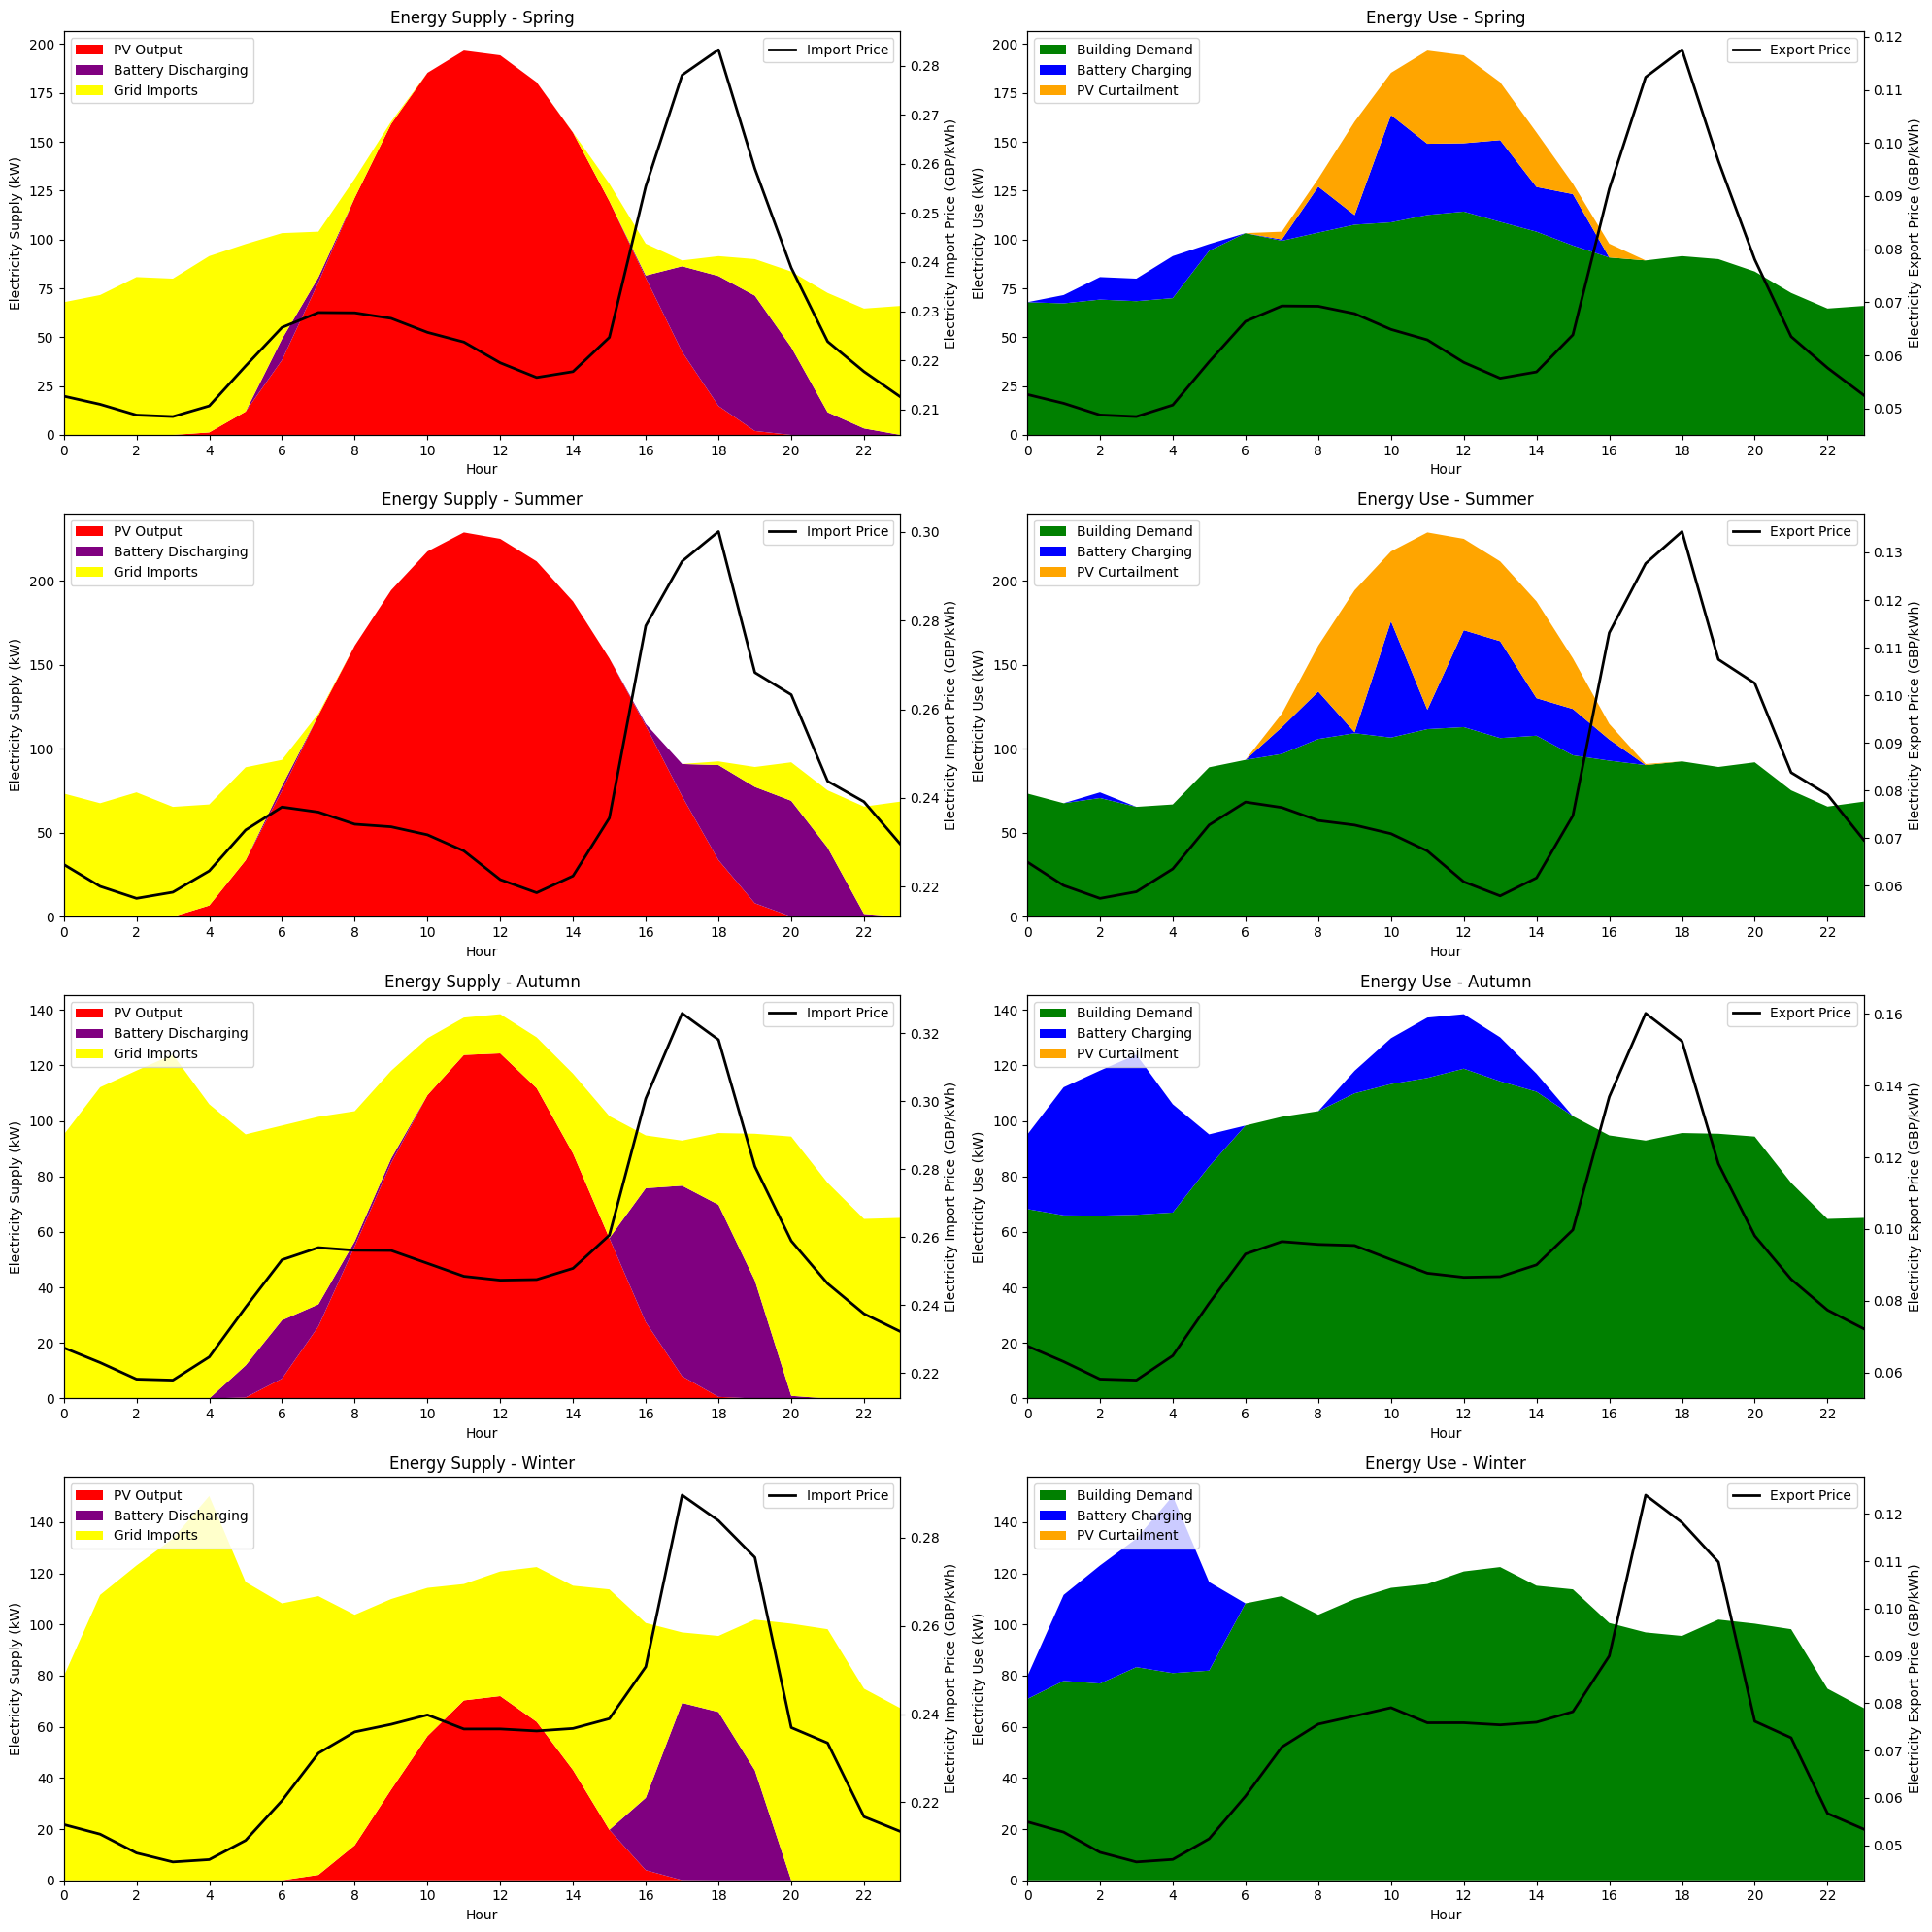

In [14]:
# Filter data for Year 0
year_0_data = extended_data[extended_data['Year'] == 0]
year_14_data = extended_data[extended_data['Year'] == 14]

# Update the mapping of day types to the months and seasons
season_mapping = {
    'Spring': [5, 6, 7, 8, 9, 10],
    'Summer': [11, 12, 13, 14, 15, 16],
    'Autumn': [17, 18, 19, 20, 21, 22],
    'Winter': [1, 2, 3, 4, 23, 24]
}

# Specify the colors for each season
season_colors = {
    'Winter': 'blue',
    'Spring': 'green',
    'Summer': 'red',
    'Autumn': 'orange'
}

# Function to get the average values for each season
def get_seasonal_averages(data, season_day_types):
    seasonal_data = data[data['DayType_i'].isin(season_day_types)]
    return seasonal_data.groupby('Hour').mean()

# Colors for the plots
colors_supply = {
    'PV Generation': 'red',
    'Battery Discharge': 'purple',
    'Grid Imports': 'yellow'
}

colors_use = {
    'Building Demand': 'green',
    'Battery Charge': 'blue',
    'Grid Export': 'brown',
    'PV Curtailment': 'orange',
}

if ex_op == 0:
    labelex='PV Curtailment'
else:
    labelex='Grid Export'

if selected_pv_type:
    labelpv='PV Output'
else:
    labelpv=None

if selected_batt_type:
    labelc='Battery Charging'
    labeld='Battery Discharging'
else:
    labelc=None
    labeld=None

# Plot each parameter with the adjusted season mapping and specified colors
fig_eb, axs_eb = plt.subplots(4, 2, figsize=(20, 20))
axs_eb = axs_eb.flatten()

for i, (season, day_type) in enumerate(season_mapping.items()):
    seasonal_avg = get_seasonal_averages(year_0_data, day_type)
    
    ax1 = axs_eb[i*2]
    ax2 = axs_eb[i*2+1]

    # Energy production plot
    ax1.stackplot(seasonal_avg.index, 
                       seasonal_avg['PV Energy Output (kWh)'], 
                       seasonal_avg['Battery Discharging (kWh)'], 
                       seasonal_avg['Grid Import (kWh)'],
                       labels=[labelpv, labeld, 'Grid Imports'],
                       colors=[colors_supply['PV Generation'], colors_supply['Battery Discharge'], colors_supply['Grid Imports']],
                       #edgecolor='black'
                       )
    
    ax1.set_title(f'Energy Supply - {season}')
    ax1.set_xlabel('Hour')
    ax1.set_ylabel('Electricity Supply (kW)')
    ax1.set_xlim(0, 23)
    ax1.set_xticks(np.arange(0, 24, 2))
    ax1.legend(loc='upper left')

    ax1_sec = ax1.twinx()
    ax1_sec.plot(seasonal_avg.index, seasonal_avg['Import Price (GBP/kWh)'], label='Import Price', color='black', linewidth=2)
    ax1_sec.set_ylabel('Electricity Import Price (GBP/kWh)')
    ax1_sec.legend(loc='upper right')
    
    # Energy use plot
    ax2.stackplot(seasonal_avg.index, 
                         seasonal_avg['Energy Demand (kWh)'], 
                         seasonal_avg['Battery Charging (kWh)'], 
                         seasonal_avg['Grid Export (kWh)'],
                         labels=['Building Demand', labelc, labelex],
                         colors=[colors_use['Building Demand'], colors_use['Battery Charge'], colors_use[labelex]],
                         #edgecolor='black'
                         )
    
    ax2.set_title(f'Energy Use - {season}')
    ax2.set_xlabel('Hour')
    ax2.set_ylabel('Electricity Use (kW)')
    ax2.set_xlim(0, 23)
    ax2.set_xticks(np.arange(0, 24, 2))
    ax2.legend(loc='upper left')

    ax2_sec = ax2.twinx()
    ax2_sec.plot(seasonal_avg.index, seasonal_avg['Export Price (GBP/kWh)'], label='Export Price', color='black', linewidth=2)
    ax2_sec.set_ylabel('Electricity Export Price (GBP/kWh)')
    ax2_sec.legend(loc='upper right')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

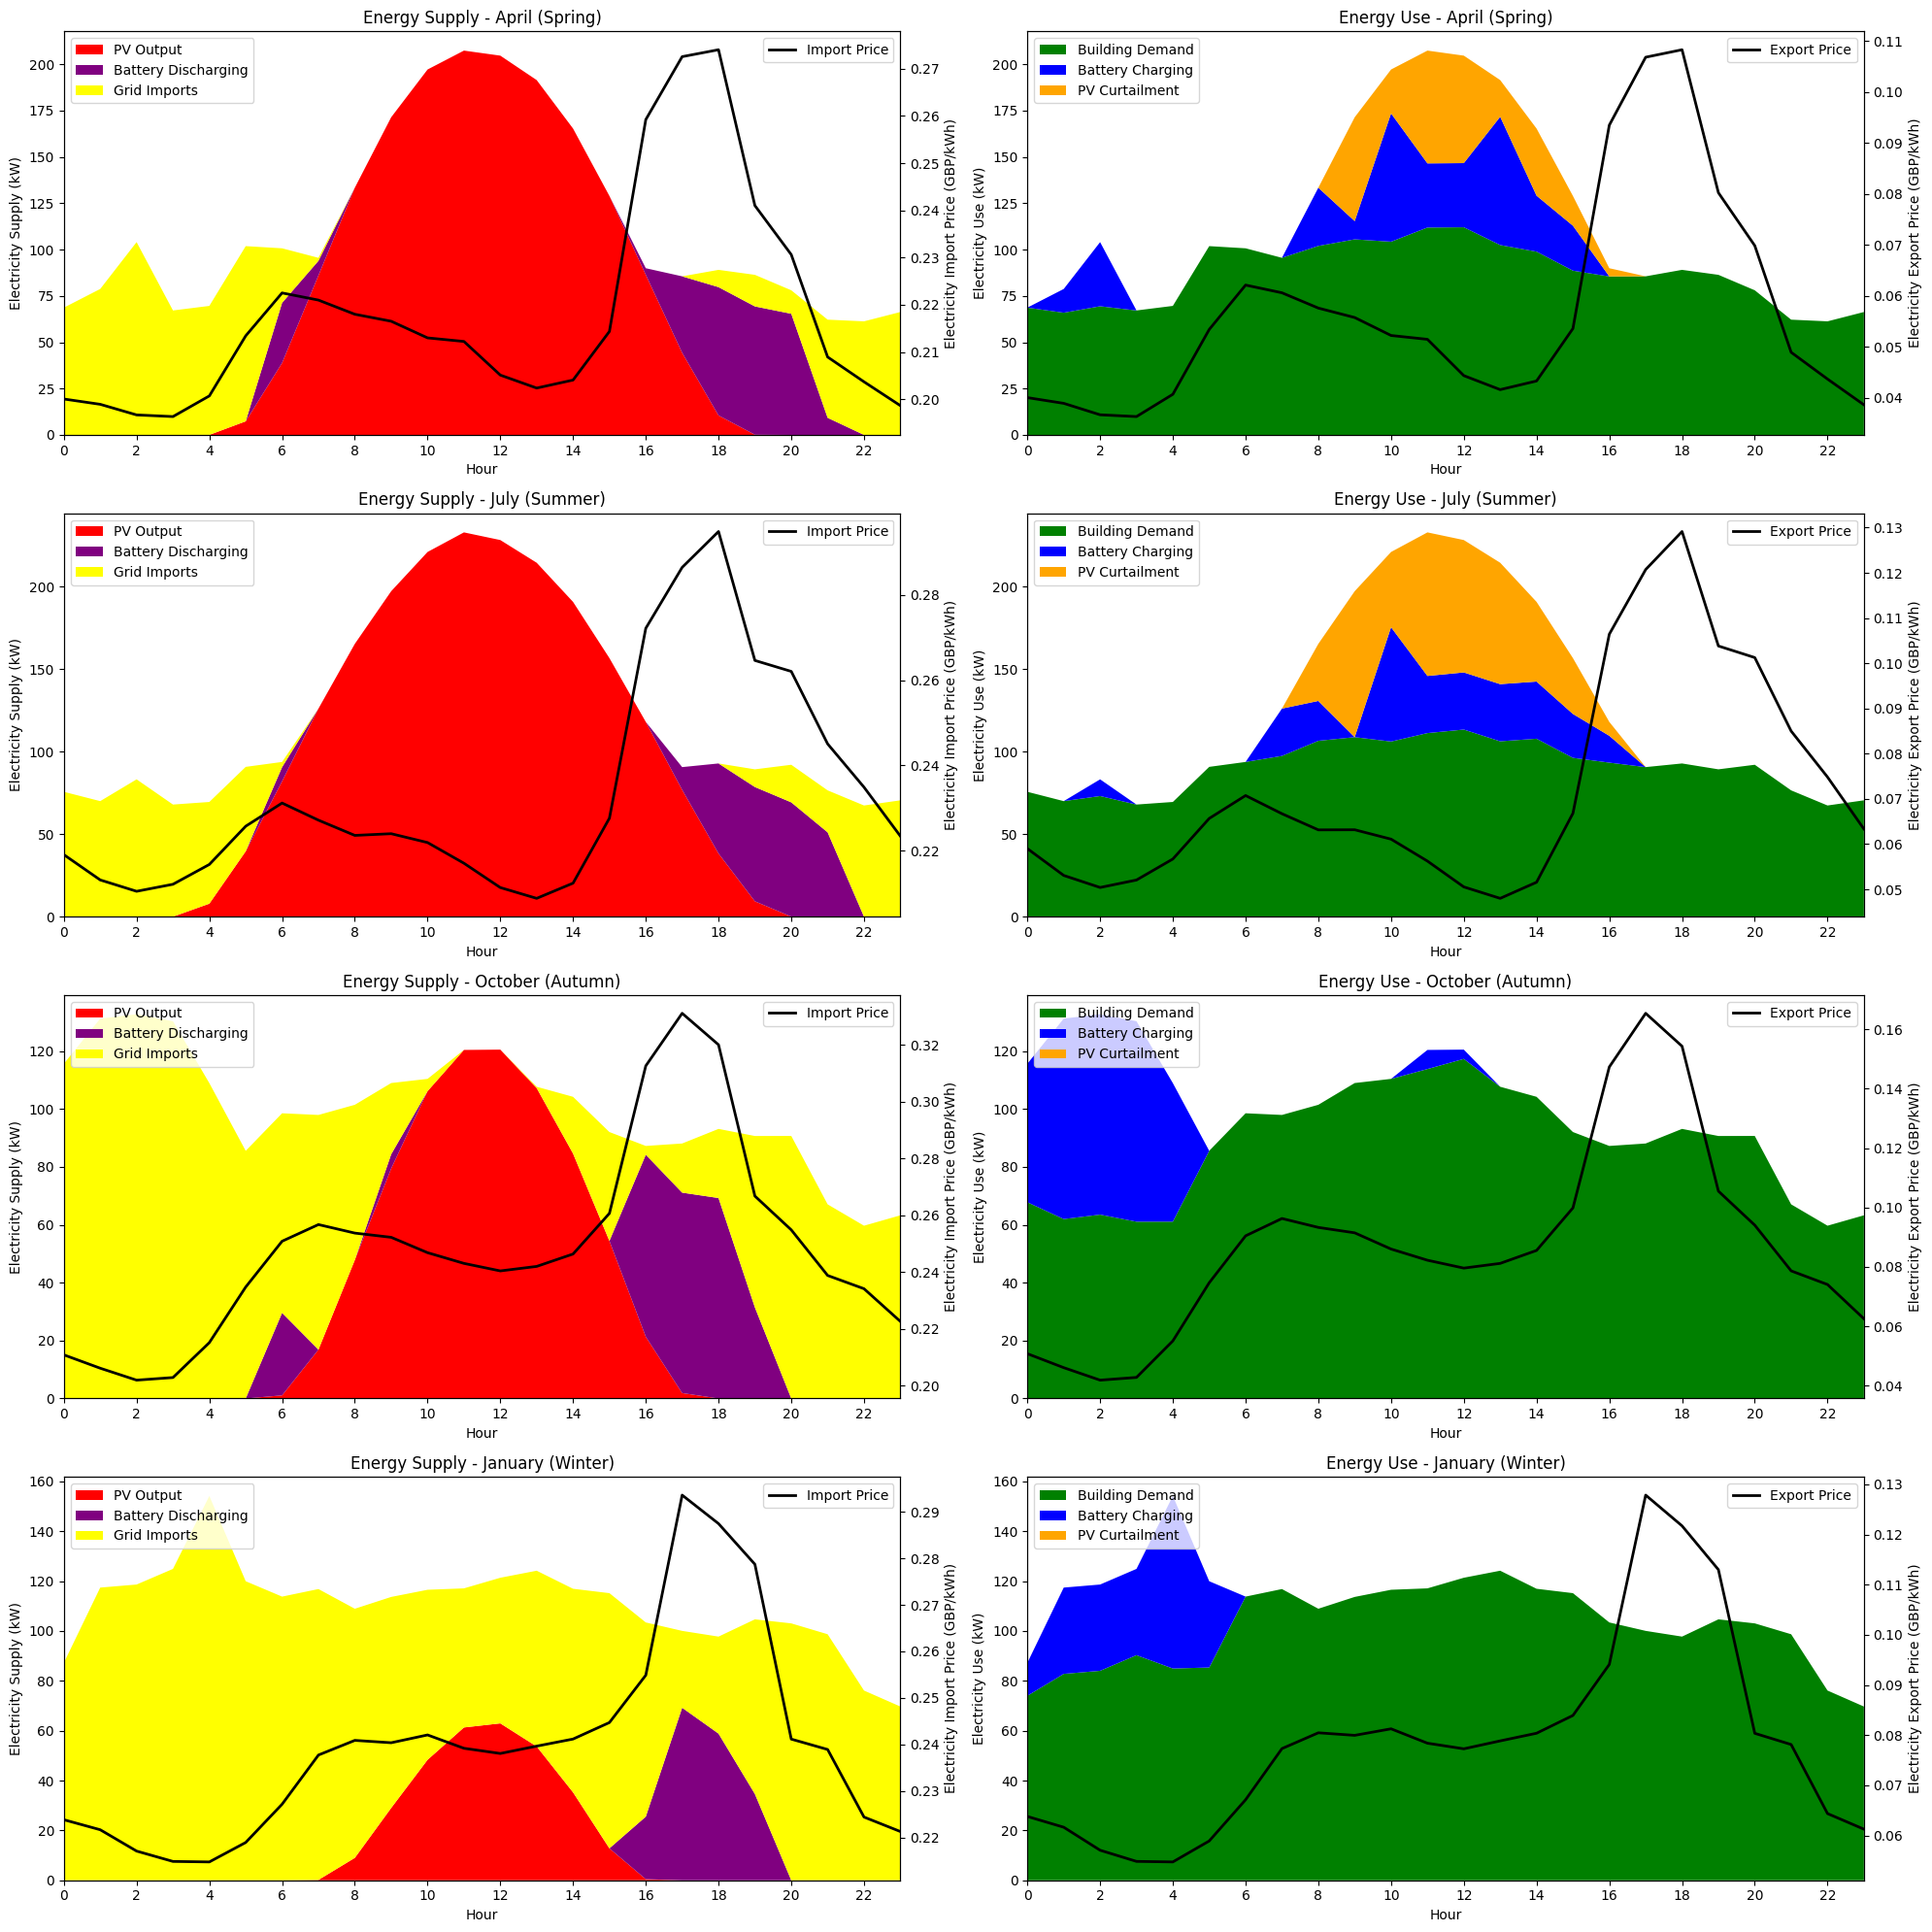

In [15]:
# Update the mapping of day types to the months and seasons
season_mapping2 = {
    'April (Spring)': [7, 8],
    'July (Summer)': [13, 14],
    'October (Autumn)': [19, 20],
    'January (Winter)': [1, 2]
}

# Plot each parameter with the adjusted season mapping and specified colors
fig_ebs, axs_ebs = plt.subplots(4, 2, figsize=(20, 20))
axs_ebs = axs_ebs.flatten()

for i, (season, day_type) in enumerate(season_mapping2.items()):
    seasonal_avg2 = get_seasonal_averages(year_0_data, day_type)
    
    axs1 = axs_ebs[i*2]
    axs2 = axs_ebs[i*2+1]

    # Energy production plot
    axs1.stackplot(seasonal_avg2.index, 
                       seasonal_avg2['PV Energy Output (kWh)'], 
                       seasonal_avg2['Battery Discharging (kWh)'], 
                       seasonal_avg2['Grid Import (kWh)'],
                       labels=[labelpv, labeld, 'Grid Imports'],
                       colors=[colors_supply['PV Generation'], colors_supply['Battery Discharge'], colors_supply['Grid Imports']],
                       #edgecolor='black'
                       )
    
    axs1.set_title(f'Energy Supply - {season}')
    axs1.set_xlabel('Hour')
    axs1.set_ylabel('Electricity Supply (kW)')
    axs1.set_xlim(0, 23)
    axs1.set_xticks(np.arange(0, 24, 2))
    axs1.legend(loc='upper left')

    axs1_sec = axs1.twinx()
    axs1_sec.plot(seasonal_avg2.index, seasonal_avg2['Import Price (GBP/kWh)'], label='Import Price', color='black', linewidth=2)
    axs1_sec.set_ylabel('Electricity Import Price (GBP/kWh)')
    axs1_sec.legend(loc='upper right')
    
    # Energy use plot
    axs2.stackplot(seasonal_avg2.index, 
                         seasonal_avg2['Energy Demand (kWh)'], 
                         seasonal_avg2['Battery Charging (kWh)'], 
                         seasonal_avg2['Grid Export (kWh)'],
                         labels=['Building Demand', labelc, labelex],
                         colors=[colors_use['Building Demand'], colors_use['Battery Charge'], colors_use[labelex]],
                         #edgecolor='black'
                         )
    
    axs2.set_title(f'Energy Use - {season}')
    axs2.set_xlabel('Hour')
    axs2.set_ylabel('Electricity Use (kW)')
    axs2.set_xlim(0, 23)
    axs2.set_xticks(np.arange(0, 24, 2))
    axs2.legend(loc='upper left')

    axs2_sec = axs2.twinx()
    axs2_sec.plot(seasonal_avg2.index, seasonal_avg2['Export Price (GBP/kWh)'], label='Export Price', color='black', linewidth=2)
    axs2_sec.set_ylabel('Electricity Export Price (GBP/kWh)')
    axs2_sec.legend(loc='upper right')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

### Step-11: Calculate financial indicators

Calculate BaU Costs

In [16]:
# Calculate BAU costs
Op_cost_bau = {}

# Iterate over year, day types and hours
for year, year_data in year_group:
    
    # Group data in year_data by day type
    day_group = year_data.groupby('DayType_i')

    Op_cost_bau[year] = 0.0

    for day, day_data in day_group:

        for idx, row in day_data.iterrows():
            
            Op_cost_bau[year] = Op_cost_bau[year] + row['Energy Demand (kWh)'] * row['Import Price (GBP/kWh)'] * day_count.loc[day, 'DayCount'] * present_val[year]

total_bau = sum(Op_cost_bau[year] for year in range(years_sim))

print("Total BaU Costs: GBP", total_bau)

Total BaU Costs: GBP 1814427.084913101


Calculate Financial Indicators

In [17]:
# For financial calculations, it is assumed that no revenue is generated at year-0, only negative cash flow
# from CAPEX is considered. As a result, timestamps are shifted +1 for operational costs and 
# maintenance costs. Present values for these shifted costs are adjusted accordingly.

cf_npv = {}
cf_irr = {}

for year in range(years_sim + 1):
    if year == 0:
        cf_npv[year] = - C_CAP_act
        cf_irr[year] = pl.value(( - C_CAP_act) / present_val[year])
    else:
        cf_npv[year] = ((Op_cost_bau[year - 1] - Op_cost[year - 1]) - C_My[year - 1] - CbattR[year - 1] - CpvR[year - 1] - CinvR[year - 1]) / present_val[year - 1] * present_val[year]
        cf_irr[year] = pl.value(((Op_cost_bau[year - 1] - Op_cost[year - 1]) - C_My[year - 1] - CbattR[year - 1] - CpvR[year - 1] - CinvR[year - 1]) / present_val[year - 1])

NPV = pl.lpSum(cf_npv[year] for year in range(years_fin + 1))
IRR = npf.irr([cf_irr[year] for year in range(years_fin + 1)])
ROI = pl.value(NPV) / pl.value(C_CAP_act)
# PI = (NPV + pl.value(C_CAP_act)) / pl.value(C_CAP_act)

# Calculate Payback Period
cumulative_cash_flow = 0 # Initialise cumulative cashflow
payback_period = None # Initialise payback period
cash_flows = []
# Iterate through each year's cash flow to calculate the cumulative cash flow
for year in range(years_sim + 1):
    # Convert cf_npv[year] to its numeric value
    year_cash_flow = pl.value(cf_npv[year])
    cumulative_cash_flow += year_cash_flow  # Update the cumulative cash flow
    cash_flows.append(cumulative_cash_flow)
    if cumulative_cash_flow >= 0:  # Check if the cumulative cash flow has recovered the initial investment
        # Calculate the exact payback period including fractional years
        if year_cash_flow > 0:
            payback_period = pl.value((year - 1) - (cumulative_cash_flow - year_cash_flow) / year_cash_flow)
            break

# Extrapolate if payback period is beyond the simulation period
if payback_period is None:
    # Number of years to consider for extrapolation
    extrapolate_years = years_sim + 1
    if len(cash_flows) >= extrapolate_years:
        # Calculate the slope (average annual growth) of cumulative cash flow for the last few years
        x = np.arange(years_sim + 1 - extrapolate_years, years_sim + 1)
        y = np.array(cash_flows[-extrapolate_years:])
        slope, intercept = np.polyfit(x, y, 1)
            
        # Calculate the remaining amount needed to reach payback
        remaining_cash_flow = -cumulative_cash_flow
            
        # Estimate additional years required to reach payback
        additional_years = remaining_cash_flow / slope
            
        # Estimate payback period
        payback_period = years_sim + 1 + additional_years
    else:
        payback_period = -1

print(years_fin, "- year NPV: GBP", pl.value(NPV))
print(years_fin, "- year IRR:", pl.value(IRR))
print(years_fin, "- year ROI:", pl.value(ROI))
print("Payback period:", payback_period)
# print(years_sim, "- year PI:", pl.value(PI))

5 - year NPV: GBP -24596.745334583553
5 - year IRR: 0.07186026594416584
5 - year ROI: -0.07102523244532452
Payback period: 5.507574665260324


### Step-12: Output results to CSV

In [18]:
extended_data.to_csv('Results/Optimised_op.csv')

In [19]:
if csv_out == 0:
    resultsC_df = pd.DataFrame(columns=['Objective Value (GBP)', 'Capital Cost (GBP)', 'PV Capital Cost (GBP)',
                                        'Battery Capital Cost (GBP)', 'Operating Cost (GBP)', 'Maintenance Cost (GBP)', 
                                   'PV Type', 'Number of PV modules', 'PV capacity (kW)', 
                                   'Battery Type', 'Battery capacity (kWh)', 'Battery power output (kW)'])
else:
    resultsC_df = pd.DataFrame(pd.read_csv('Results/Optimised_cap_REP.csv'))

# Calculate the results
resultsC = {
    'Objective Value (GBP)': pl.value(OF_act),
    'Operating Cost (GBP)': pl.value(C_O),
    'Capital Cost (GBP)': pl.value(C_CAP_act),
    'PV Capital Cost (GBP)': pl.value(C_CAP_pv),
    'Battery Capital Cost (GBP)': pl.value(C_CAP_batt_act),
    'Maintenance Cost (GBP)': pl.value(C_M),
    'PV Type': [pv_lib[p]['name'] for p in selected_pv_type],
    'Number of PV modules': pl.value(pl.lpSum(N_pv[p] for p in pv_type)),
    'PV capacity (kW)': pl.value(pl.lpSum(N_pv[p] * pv_lib[p]['eff_pv'] * pv_lib[p]['A_pv'] for p in pv_type)),
    'Battery Type': [batt_lib[b]['name'] for b in selected_batt_type],
    'Battery capacity (kWh)': pl.value(pl.lpSum(E_batt[b] for b in batt_type)),
    'Battery power output (kW)': pl.value(pl.lpSum(O_batt[b] * batt_mrgn for b in batt_type))
}

# Append the results to the DataFrame
resultsC_df = pd.concat([resultsC_df, pd.DataFrame([resultsC])], ignore_index=True)

# Save the DataFrame to a CSV file
resultsC_df.to_csv('Results/Optimised_cap.csv', index=False)

C:\Users\brant\AppData\Local\Temp\ipykernel_139480\1922648937.py:26: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  resultsC_df = pd.concat([resultsC_df, pd.DataFrame([resultsC])], ignore_index=True)


In [20]:
if csv_out == 0:
    resultsF_df = pd.DataFrame(columns=['Year basis (years)','NPV (GBP)', 'IRR', 'ROI', 'Payback period (years)'])
else:
    resultsF_df = pd.DataFrame(pd.read_csv('Results/Financials_REP.csv'))

resultsF = {
    'Year basis (years)' : years_fin,
    'NPV (GBP)': pl.value(NPV),
    'IRR': pl.value(IRR),
    'ROI': pl.value(ROI),
    'Payback period (years)': payback_period,
}

# Append the results to the DataFrame
resultsF_df = pd.concat([resultsF_df, pd.DataFrame([resultsF])], ignore_index=True)

# Save the DataFrame to a CSV file
resultsF_df.to_csv('Results/Financials.csv', index=False)

C:\Users\brant\AppData\Local\Temp\ipykernel_139480\2677693729.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  resultsF_df = pd.concat([resultsF_df, pd.DataFrame([resultsF])], ignore_index=True)


### Step-13: Model Frequency Response Revenue

In [21]:
# Iterate over the year, day types, and hours
fr_rev = {} # Initialise dictionary
beta_fr = {}

# Initialize new columns
extended_data['FR Operation'] = 0

for year, year_data in year_group:
    
    # Group data in year_data by day type
    day_group = year_data.groupby('DayType_i')
    fr_rev[year] = {}
    beta_fr[year] = {}

    for day, day_data in day_group:
        beta_fr[year][day] = {}

        for idx, row in day_data.iterrows():
            
            hour = row['Hour']

            # Calculate yearly opearting cost
            fr_price = row['DRL (GBP/MW/hr)'] / 1000 # wholesale price + DUoS import + Misc.
            if pl.value(pl.lpSum(O_batt[b] * batt_mrgn for b in batt_type)) <= pl.value(E_batt_lvl_dict[year][day][hour]):
                fr_rev[year] = fr_rev[year] + fr_price * pl.lpSum(O_batt[b] * batt_mrgn for b in batt_type) * day_count.loc[day, 'DayCount'] * present_val[year]
                beta_fr[year][day][hour] = 1
            else:
                 fr_rev[year] = fr_rev[year]
                 beta_fr[year][day][hour] = 0

            extended_data.at[idx, 'FR Operation'] = beta_fr[year][day][hour]

C_FR = pl.lpSum([fr_rev[year] for year in range(years_sim)]) # Total operating cost

pl.value(C_FR)

np.float64(53434.18125665503)

In [22]:
# For financial calculations, it is assumed that no revenue is generated at year-0, only negative cash flow
# from CAPEX is considered. As a result, timestamps are shifted +1 for operational costs and 
# maintenance costs. Present values for these shifted costs are adjusted accordingly.

cf_npv_fr = {}
cf_irr_fr = {}

for year in range(years_sim + 1):
    if year == 0:
        cf_npv_fr[year] = - C_CAP_act
        cf_irr_fr[year] = pl.value(( - C_CAP_act) / present_val[year])
    else:
        cf_npv_fr[year] = ((Op_cost_bau[year - 1] - Op_cost[year - 1]) - C_My[year - 1] - CbattR[year - 1] - CpvR[year - 1] - CinvR[year - 1] + fr_rev[year - 1]) / present_val[year - 1] * present_val[year]
        cf_irr_fr[year] = pl.value(((Op_cost_bau[year - 1] - Op_cost[year - 1]) - C_My[year - 1] - CbattR[year - 1] - CpvR[year - 1] - CinvR[year - 1] + fr_rev[year - 1]) / present_val[year - 1])

NPV_FR = pl.lpSum(cf_npv_fr[year] for year in range(years_fin + 1))
IRR_FR = npf.irr([cf_irr_fr[year] for year in range(years_fin + 1)])
ROI_FR = pl.value(NPV_FR) / pl.value(C_CAP_act)
# PI = (NPV + pl.value(C_CAP_act)) / pl.value(C_CAP_act)

# Calculate Payback Period
cumulative_cash_flow_fr = 0 # Initialise cumulative cashflow
payback_period_fr = None # Initialise payback period
cash_flows_fr = []
# Iterate through each year's cash flow to calculate the cumulative cash flow
for year in range(years_sim + 1):
    # Convert cf_npv[year] to its numeric value
    year_cash_flow_fr = pl.value(cf_npv_fr[year])
    cumulative_cash_flow_fr += year_cash_flow_fr  # Update the cumulative cash flow
    cash_flows_fr.append(cumulative_cash_flow_fr)
    if cumulative_cash_flow_fr >= 0:  # Check if the cumulative cash flow has recovered the initial investment
        # Calculate the exact payback period including fractional years
        if year_cash_flow_fr > 0:
            payback_period_fr = pl.value((year - 1) - (cumulative_cash_flow_fr - year_cash_flow_fr) / year_cash_flow_fr)
            break

# Extrapolate if payback period is beyond the simulation period
if payback_period_fr is None:
    # Number of years to consider for extrapolation
    extrapolate_years_fr = years_sim + 1
    if len(cash_flows) >= extrapolate_years_fr:
        # Calculate the slope (average annual growth) of cumulative cash flow for the last few years
        x_fr = np.arange(years_sim + 1 - extrapolate_years_fr, years_sim + 1)
        y_fr = np.array(cash_flows[-extrapolate_years_fr:])
        slope_fr, intercept_fr = np.polyfit(x_fr, y_fr, 1)
            
        # Calculate the remaining amount needed to reach payback
        remaining_cash_flow_fr = -cumulative_cash_flow_fr
            
        # Estimate additional years required to reach payback
        additional_years_fr = remaining_cash_flow_fr / slope_fr
            
        # Estimate payback period
        payback_period_fr = years_sim + 1 + additional_years_fr
    else:
        payback_period_fr = -1

print(years_fin, "- year NPV (with FR): GBP", pl.value(NPV_FR))
print(years_fin, "- year IRR (with FR):", pl.value(IRR_FR))
print(years_fin, "- year ROI (with FR):", pl.value(ROI_FR))
# print(years_sim, "- year PI:", pl.value(PI))
print("Payback period:", payback_period_fr)

5 - year NPV (with FR): GBP -386.7352936443921
5 - year IRR (with FR): 0.09956379991880948
5 - year ROI (with FR): -0.0011167316550325557
Payback period: 5.007428018029166


In [23]:
if csv_out == 0:
    resultsF_df = pd.DataFrame(columns=['Year basis (years)','NPV (GBP)', 'IRR', 'ROI', 'Payback period (years)'])
else:
    resultsF_df = pd.DataFrame(pd.read_csv('Results/Financials_REP+FR.csv'))

resultsF = {
    'Year basis (years)' : years_fin,
    'NPV (GBP)': pl.value(NPV_FR),
    'IRR': pl.value(IRR_FR),
    'ROI': pl.value(ROI_FR),
    'Payback period (years)': payback_period_fr,
}

# Append the results to the DataFrame
resultsF_df = pd.concat([resultsF_df, pd.DataFrame([resultsF])], ignore_index=True)

# Save the DataFrame to a CSV file
resultsF_df.to_csv('Results/Financials_withFR.csv', index=False)

C:\Users\brant\AppData\Local\Temp\ipykernel_139480\9280749.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  resultsF_df = pd.concat([resultsF_df, pd.DataFrame([resultsF])], ignore_index=True)
